In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torchvision import transforms, utils
from torchvision.datasets.mnist import MNIST

from poutyne import set_seeds, Model

In [2]:
set_seeds(42)

In [3]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

train_split_percent = 0.8

num_classes = 10

batch_size = 32
learning_rate = 0.1
num_epochs = 1

In [4]:
full_train_dataset = MNIST('./mnist/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('./mnist/', train=False, download=True, transform=transforms.ToTensor())

num_data = len(full_train_dataset)
indices = list(range(num_data))
np.random.shuffle(indices)

split = math.floor(train_split_percent * num_data)

train_indices = indices[:split]
train_dataset = Subset(full_train_dataset, train_indices)

valid_indices = indices[split:]
valid_dataset = Subset(full_train_dataset, valid_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

loaders = train_loader, valid_loader, test_loader

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


/Users/ashish.jha/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


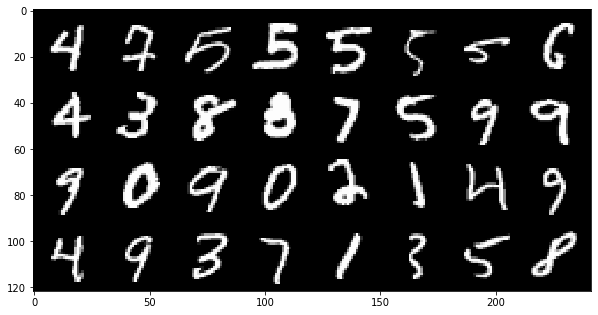

In [5]:
inputs = next(iter(train_loader))[0]
input_grid = utils.make_grid(inputs)

fig = plt.figure(figsize=(10, 10))
inp = input_grid.numpy().transpose((1, 2, 0))
plt.imshow(inp)
plt.show()

In [6]:
def create_convolutional_network():
    """
    This function returns the convolutional network layed out above.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(32*7*7, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, num_classes)
    )

In [7]:
def poutyne_train(pytorch_network):
    """
    This function creates a Poutyne Model (see https://poutyne.org/model.html), sends the
    Model on the specified device, and uses the `fit_generator` method to train the
    neural network. At the end, the `evaluate_generator` is used on  the test set.

    Args:
        pytorch_network (torch.nn.Module): The neural network to train.
    """
    print(pytorch_network)

    optimizer = optim.SGD(pytorch_network.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    # Poutyne Model
    model = Model(pytorch_network, optimizer, loss_function, batch_metrics=['accuracy'])

    # Send model on GPU
    model.to(device)

    # Train
    model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

    # Test
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

In [9]:
conv_net = create_convolutional_network()
poutyne_train(conv_net)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.25, inplace=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1568, out_features=128, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=128, out_features=10, bias=True)
)
Epoch: 1/1 Step: 1500/1500 100.00% |█████████████████████████|16.48s loss: 0.366709 acc: 88.368750 val_loss: 0.085108 val_acc: 97.375000
Test:
	Loss: 0.07625559615637176
	Accuracy: 97.55
